In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
torch.cuda.is_available()

True

In [3]:
mean_gray= 0.1307
stddev_gray= 0.3081
#normalize the image with std and mean
#e.g: input[channel]=(input[channel]-mean[channel])/std(channel)
transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean_gray,),(stddev_gray,))])

train_dataset=datasets.MNIST(root='./data', train=True, transform=transforms, download=True)
test_dataset=datasets.MNIST(root='./data', train=False, transform=transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 20462403.72it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 333421.36it/s]
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5114397.60it/s]                           
8192it [00:00, 131788.39it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


label: 0


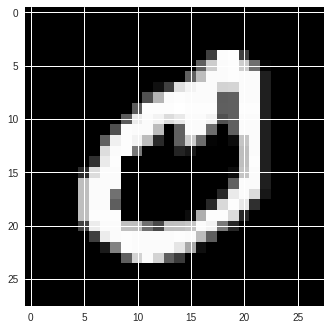

In [18]:
import matplotlib.pyplot as plt
label=train_dataset[21][1]
print('label:', label)
random_image = train_dataset[21][0].numpy() * stddev_gray + mean_gray
plt.imshow(random_image.reshape(28,28), cmap='gray')

In [0]:
batch_size=100
epochs=10
train_load=torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_load=torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
print("Number of images in training set: {}".format(len(train_dataset)))
print("Number of images in test set: {}".format(len(test_dataset)))
print("Number of batches in the train loader: {}".format(len(train_load)))
print("Number of batches in the test loader: {}".format(len(test_load)))

Number of images in training set: 60000
Number of images in test set: 10000
Number of batches in the train loader: 600
Number of batches in the test loader: 100


In [0]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    # input_size:28, same_padding=(filter_size-1)/2, 3-1/2=1:padding
    self.cnn1=nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
    # input_size-filter_size +2(padding)/stride + 1 = 28-3+2(1)/1+1=28
    self.batchnorm1=nn.BatchNorm2d(8)
    # output_channel:8, batch(8)
    self.relu=nn.ReLU()
    self.maxpool1=nn.MaxPool2d(kernel_size=2)
    #input_size=28/2=14
    self.cnn2=nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
    # same_padding: (5-1)/2=2:padding_size. 
    self.batchnorm2=nn.BatchNorm2d(32)
    self.maxpool2=nn.MaxPool2d(kernel_size=2)
    # input_size=14/2=7
    # 32x7x7=1568
    self.fc1 =nn.Linear(in_features=1568, out_features=600)
    self.dropout= nn.Dropout(p=0.5)
    self.fc2 =nn.Linear(in_features=600, out_features=10)
  def forward(self,x):
    out =self.cnn1(x)
    out =self.batchnorm1(out)
    out =self.relu(out)
    out =self.maxpool1(out)
    out =self.cnn2(out)
    out =self.batchnorm2(out)
    out =self.relu(out)
    out =self.maxpool2(out)
    out =out.view(-1,1568)
    out =self.fc1(out)
    out =self.relu(out)
    out =self.dropout(out)
    out =self.fc2(out)
    return out

In [0]:
model=CNN()
CUDA=torch.cuda.is_available()
if CUDA:
  model=model.cuda()
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adadelta(model.parameters(), lr=0.01)

In [27]:
iteration=0
correct_nodata=0
correct_data=0
for i,(inputs,labels) in enumerate (train_load):
  if iteration==1:
    break
  inputs=Variable(inputs)
  labels=Variable(labels)
  if torch.cuda.is_available():
    inputs=inputs.cuda()
    labels=labels.cuda()
  print("For 1 iteration, this is what happens:")
  print("Input Shape:",inputs.shape)
  print("Labels Shape:", labels.shape)
  output = model(inputs)
  print("Output Shape:",output.shape)
  _,predicted_nodata=torch.max(output,1)
  print("Predicted Shape:",predicted_nodata.shape)
  print("Predicted Tensor:",predicted_nodata)
  correct_nodata +=(predicted_nodata==labels).sum()
  print("Correct Predictions:",correct_nodata)
  _,predicted_data = torch.max(output.data,1)
  correct_data +=(predicted_data==labels.data).sum()
  print("Correct Predictions:",correct_data)
  
  iteration+=1

For 1 iteration, this is what happens:
Input Shape: torch.Size([100, 1, 28, 28])
Labels Shape: torch.Size([100])
Output Shape: torch.Size([100, 10])
Predicted Shape: torch.Size([100])
Predicted Tensor: tensor([4, 9, 5, 0, 9, 3, 9, 3, 3, 7, 6, 1, 9, 4, 9, 3, 9, 7, 2, 2, 9, 1, 9, 2,
        2, 9, 1, 9, 9, 0, 3, 0, 2, 3, 0, 4, 5, 6, 0, 0, 4, 7, 3, 2, 7, 9, 2, 3,
        0, 2, 9, 0, 4, 9, 9, 9, 7, 3, 9, 6, 4, 9, 2, 0, 4, 2, 3, 9, 4, 2, 1, 0,
        4, 4, 2, 2, 2, 1, 2, 3, 0, 2, 4, 4, 0, 0, 4, 8, 9, 8, 4, 3, 3, 9, 4, 9,
        7, 5, 4, 0], device='cuda:0')
Correct Predictions: tensor(12, device='cuda:0')
Correct Predictions: tensor(12, device='cuda:0')


In [31]:
num_epochs=25

train_loss=[]
test_loss=[]
train_accuracy=[]
test_accuracy=[]

# Training
for epoch in range(num_epochs):
  # Reset variables at 0 epoch
  correct=0
  iteration=0
  iter_loss=0.0
  
  model.train() # Training Mode
  
  for i,(inputs,labels) in enumerate(train_load):
    
    inputs=Variable(inputs)
    labels=Variable(labels)
    
    # if CUDA is avaible, shift to GPU (CUDA)
    CUDA=torch.cuda.is_available()
    if CUDA:
      inputs=inputs.cuda()
      labels=labels.cuda()
      
    optimizer.zero_grad() # clear gradient
    outputs=model(inputs)
    loss=loss_fn(outputs,labels)
    iter_loss += loss.item() # Accumulate loss
    loss.backward() # backpropagation
    optimizer.step() # update weights
    
    # Save the correct predictions for training data
    _,predicted=torch.max(outputs,1)
    correct +=(predicted==labels).sum()
    iteration +=1
    
  train_loss.append(iter_loss/iteration)
  train_accuracy.append((100*correct/len(train_dataset)))
  
  # Testing
  correct=0
  iteration=0
  loss=0.0
  
  model.eval()  # Testing Mode
  
  for i, (inputs, labels) in enumerate(test_load):
    
    inputs=Variable(inputs)
    labels=Variable(labels)
    
    CUDA=torch.cuda.is_available()
    if CUDA:
      inputs=inputs.cuda()
      labels=labels.cuda()
    
    outputs=model(inputs)
    loss=loss_fn(outputs,labels)
    loss += loss.item()
    
    _,predicted=torch.max(outputs,1)
    correct+=(predicted==labels).sum()
    
    iteration+=1
    
  test_loss.append(loss/iteration)
  test_accuracy.append((100*correct/len(test_dataset)))
  
  print('Epoch {}/{}, Training Loss:{:.3f}, Training Accuracy:{:.3f}, Testing Loss {:.3f}, Testing Accuracy:{:.3f}'
       .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1]))
  
    

Epoch 1/25, Training Loss:0.281, Training Accuracy:92.000, Testing Loss 0.006, Testing Accuracy:94.000
Epoch 2/25, Training Loss:0.215, Training Accuracy:94.000, Testing Loss 0.004, Testing Accuracy:95.000
Epoch 3/25, Training Loss:0.178, Training Accuracy:94.000, Testing Loss 0.003, Testing Accuracy:96.000
Epoch 4/25, Training Loss:0.153, Training Accuracy:95.000, Testing Loss 0.003, Testing Accuracy:96.000
Epoch 5/25, Training Loss:0.137, Training Accuracy:96.000, Testing Loss 0.002, Testing Accuracy:97.000
Epoch 6/25, Training Loss:0.124, Training Accuracy:96.000, Testing Loss 0.002, Testing Accuracy:97.000
Epoch 7/25, Training Loss:0.113, Training Accuracy:96.000, Testing Loss 0.002, Testing Accuracy:97.000
Epoch 8/25, Training Loss:0.105, Training Accuracy:96.000, Testing Loss 0.002, Testing Accuracy:97.000
Epoch 9/25, Training Loss:0.098, Training Accuracy:97.000, Testing Loss 0.002, Testing Accuracy:97.000
Epoch 10/25, Training Loss:0.092, Training Accuracy:97.000, Testing Loss 

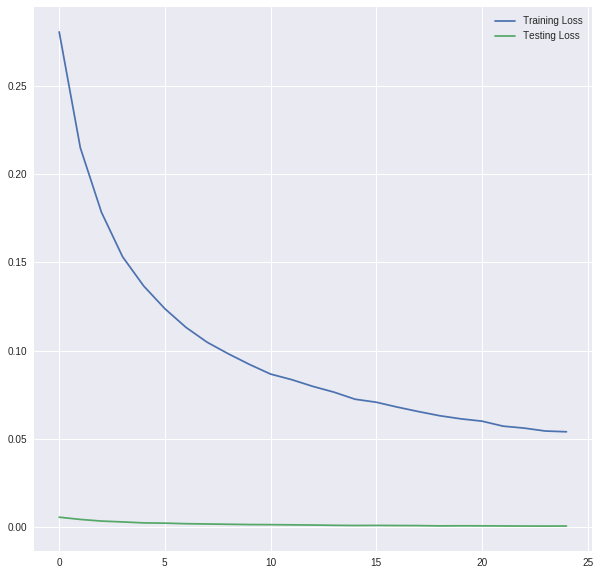

In [32]:
# Loss
f=plt.figure(figsize=(10,10))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()

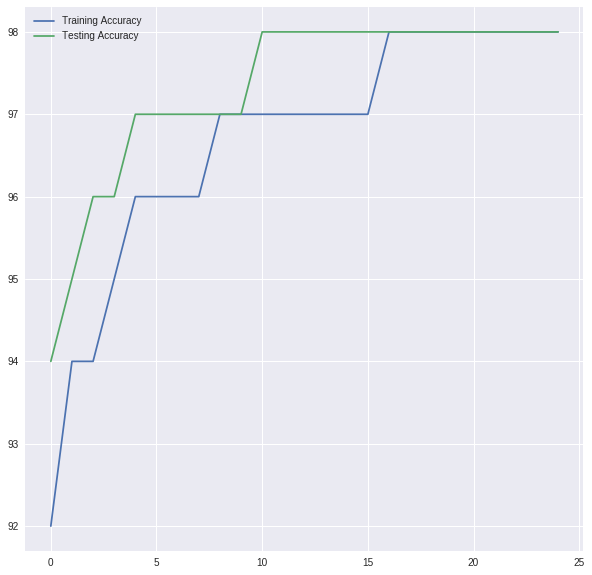

In [33]:
# Accuracy
f=plt.figure(figsize=(10,10))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend()
plt.show()

In [36]:
img= test_dataset[40][0].resize_((1,1,28,28))
img= Variable(img)
label= test_dataset[40][1]

model.eval()

if torch.cuda.is_available():
  model=model.cuda()
  img=img.cuda()
  
output=model(img)
print(output)
print(output.data)
_,predicted=torch.max(output,1)
print("Prediction is:",predicted.item())
print("Actual is:", label)

tensor([[-3.5276,  5.8716, -2.6660, -4.8475, -1.5879, -3.5000, -3.9559, -1.1305,
         -2.2470, -4.1517]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-3.5276,  5.8716, -2.6660, -4.8475, -1.5879, -3.5000, -3.9559, -1.1305,
         -2.2470, -4.1517]], device='cuda:0')
Prediction is: 1
Actual is: 1
